In [56]:
import tools
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import copy
import time
%load_ext snakeviz
import os   
import pickle
import pprint
import lit 

def increase_res(scalar,N_grid):
    st_grid = tools.ScalarTool(N_grid,L)
    th_hat = np.fft.rfft(scalar,axis = 1)

    th_hat1 = np.zeros((N,N_grid//2+1), dtype = ctype)
    th_hat1[:,0:(N//2+1)]=N_grid/N*th_hat

    th_hat2 = np.fft.fft(th_hat1,axis = 0)

    th_hat3 = np.zeros((N_grid,N_grid//2+1), dtype = ctype)
    th_hat3[0:N//2,:]=N_grid/N*th_hat2[0:N//2,:]
    th_hat3[(N_grid - N//2):,:]=N_grid/N*th_hat2[N//2:,:]
    th_new = st_grid.ifft(th_hat3)
    return th_new

def f(th,u):
    th_d = st.dealias(th)
    return st.dealias(-1.0 * np.sum(vt.dealias(u) * st.grad(th_d), 0) 
                      + kappa * st.lap(th_d))

def g(phi,u):
    phi_d = st.dealias(phi)
    return st.dealias(-1.0 * np.sum(vt.dealias(u) * st.grad(phi_d), 0) 
                      - kappa * st.lap(phi_d))

def line_search(u,d,eta_array):
    J_array = np.zeros(np.shape(eta_array))
    for i,eta in enumerate(eta_array):
        J_array[i] = get_obj(normalize(div_free_proj(dealias(u + eta*d))))
    plt.figure()
    plt.loglog(eta_array,J_array)
    plt.show()
    return eta_array[np.argmin(J_array)]

def get_obj(u):
    # Forward integration
    th = integrate_forward(u,th0)
    return 0.5*st.hm1norm(th[M-1])**2
    
def integrate_forward(u,th0):
    th = np.zeros((M,N,N))
    th[0] = th0
    for i in range(M-1):
        # Heun's method
        k1 = f(th[i],u[i])
        th_euler = th[i] + dt*k1
        th[i+1] = th[i] + 0.5*dt*(k1+f(th_euler,u[i+1]))
    return th

def integrate_backward(u,phiT):
    phi = np.zeros((M,N,N))  
    phi[M-1] = phiT
    for i in reversed(range(M-1)):
        # Heun's method
        k1 = g(phi[i+1],u[i+1])
        phi_euler = phi[i+1] - dt*k1
        phi[i] = phi[i+1] - 0.5*dt*(k1 + g(phi_euler,u[i]))
        
    return phi

def compute_gradJ_and_J(u):
    # Forward integration
    th = integrate_forward(u,th0)
        
    # Compute objective
    obj = 0.5*st.hm1norm(th[M-1])**2
    
    # Backward integration
    phiT = st.invlap(th[M-1]) 
    phi = integrate_backward(u,phiT)
    
    # Compute gradient
    grad = np.zeros((M,2,N,N))
    for i in range(M):
        grad[i] = st.dealias(phi[i])*vt.dealias(st.grad(th[i]))
        grad[i] = vt.div_free_proj(vt.dealias(grad[i]))
    lapu = lap(u)
    mu = dot(lapu,grad)/dot(lapu,lapu)
    grad = grad - mu*lapu
        
    return grad, obj

def compute_d(u):
    # Forward integration
    th = integrate_forward(u,th0)
        
    # Compute objective
    obj = 0.5*st.hm1norm(th[M-1])**2
    
    # Backward integration
    phiT = st.invlap(th[M-1]) 
    phi = integrate_backward(u,phiT)
    
    # Compute d
    d = np.zeros((M,2,N,N))
    for i in range(M):
        d[i] = st.dealias(phi[i])*vt.dealias(st.grad(th[i]))
        d[i] = vt.invlap(vt.div_free_proj(vt.dealias(d[i])))
    d = normalize(d) - u
        
    return d

def lap(v):
    lapv = np.zeros((M,2,N,N))
    for i in range(M):
        lapv[i] = vt.lap(v[i])
    return lapv   

def invlap(v):
    invlapv = np.zeros((M,2,N,N))
    for i in range(M):
        invlapv[i] = vt.invlap(v[i])
    return invlapv   

def normalize(v):
    return v*(gamma*L)/mean_enstrophy(v)**0.5

def mean_enstrophy(v):
    integ =0
    for i in range(M):
        integ += vt.h1norm(v[i])**2.*dt
    integ = (1./T)*integ
    return integ

def is_incompressible(v):
    cond = True
    for i in range(M):
        cond = cond * vt.is_incompressible(v[i])
        
    return cond == 1

def div_free_proj(v):
    for i in range(M):
        v[i] = vt.div_free_proj(vt.dealias(v[i]))
    return v

def dealias(v):
    for i in range(M):
        v[i] = vt.dealias(v[i])
    return v
    
def dot(v,u):
    dot = 0 
    for i in range(M):
        dot += st.sint(sum(v[i]*u[i],0))*dt
    
    return dot

N = 64
M = 1000
L = 1.0
h = L/N
T = 3.0
dt = T/M
kappa = 0.0
gamma = 1.0
ftype = np.float64
ctype = np.complex128

st = tools.ScalarTool(N,L)
vt = tools.VectorTool(N,L)


The snakeviz extension is already loaded. To reload it, use:
  %reload_ext snakeviz


In [50]:
sol_lit = lit.sim(N=N,M=M-1,Pe = np.inf,plot=False,T=T,save_th_every=M-1,save_u_every=1)
u = np.array(sol_lit.hist_u)
th0 = sol_lit.hist_th[0]
print(mean_enstrophy(u))
time_array = sol_lit.hist_u_time

The snakeviz extension is already loaded. To reload it, use:
  %reload_ext snakeviz
dt =  0.003003003003003003
1.0


In [28]:
eps_array = 2**(-np.linspace(1,20,5))
error_array = np.zeros(np.shape(eps_array))
gradJ, J = compute_gradJ_and_J(u)
d = -gradJ
d = d / dot(d,d)**0.5

for i,eps in enumerate(eps_array):
    
    J1 = get_obj(normalize(div_free_proj(dealias(u - eps*d))))
    J2 = get_obj(normalize(div_free_proj(dealias(u + eps*d))))
 
    numerical_gradJ = (J2 - J1)/(2.*eps)
    analytic_gradJ =dot(gradJ,d)
    error = abs(numerical_gradJ - analytic_gradJ)/abs(analytic_gradJ)
    error_array[i] = error
    print(eps,error)
    

0.5 1.03706018756
0.0185813611719 0.0906595675568
0.000690533966002 0.000837804123593
2.56621220475e-05 0.00070967367386
9.53674316406e-07 0.000709496727641


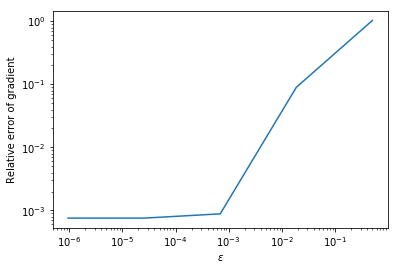

In [13]:
plt.loglog(eps_array,error_array)
#plt.ylim([8.e-5,0.2e-3])
plt.xlabel(r'$\epsilon$')
plt.ylabel('Relative error of gradient')
plt.savefig('gradient.eps',dpi = 300,format = 'eps')
plt.show()

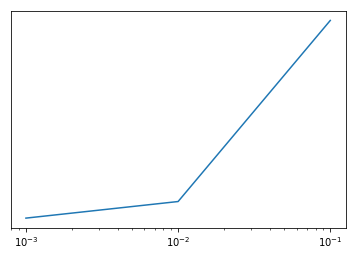

eta= 0.001 mag of gradJ =  3.30983590139e-06 mag d =  8.28941739639e-06 J= 0.000673730174128 incompressible? True mean enstrophy 1.0


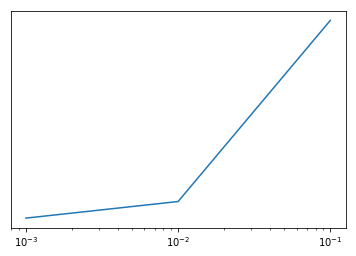

eta= 0.001 mag of gradJ =  3.30874880985e-06 mag d =  8.28653672076e-06 J= 0.000673730174131 incompressible? True mean enstrophy 1.0


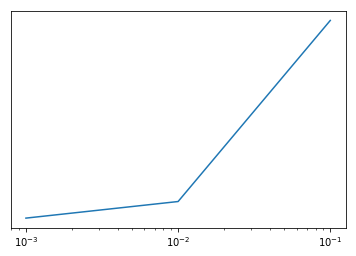

eta= 0.001 mag of gradJ =  3.30766213327e-06 mag d =  8.28365760824e-06 J= 0.000673730174134 incompressible? True mean enstrophy 1.0


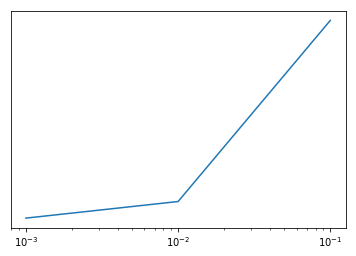

eta= 0.001 mag of gradJ =  3.30657587109e-06 mag d =  8.28078004939e-06 J= 0.000673730174137 incompressible? True mean enstrophy 1.0


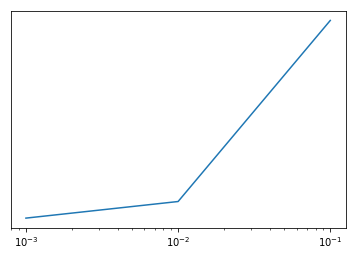

eta= 0.001 mag of gradJ =  3.30549002279e-06 mag d =  8.2779040343e-06 J= 0.00067373017414 incompressible? True mean enstrophy 1.0


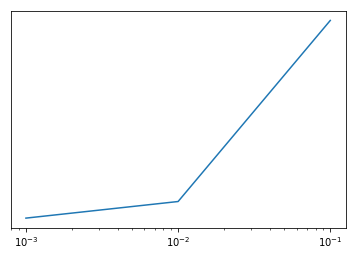

eta= 0.001 mag of gradJ =  3.30440458784e-06 mag d =  8.27502955304e-06 J= 0.000673730174143 incompressible? True mean enstrophy 1.0


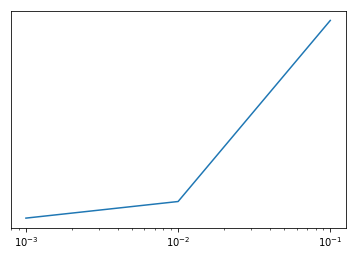

eta= 0.001 mag of gradJ =  3.3033195657e-06 mag d =  8.27215659619e-06 J= 0.000673730174147 incompressible? True mean enstrophy 1.0


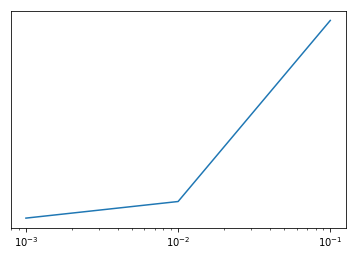

eta= 0.001 mag of gradJ =  3.30223495585e-06 mag d =  8.26928515423e-06 J= 0.00067373017415 incompressible? True mean enstrophy 1.0


KeyboardInterrupt: 

In [48]:
eta_array = np.array([0.1,.01,0.001])
num_iterations = 100
for i in range(num_iterations):
    gradJ, J = compute_gradJ_and_J(u)
    #d = -gradJ
    d = compute_d(u)
    #d = d / dot(d,d)**0.5
    eta = line_search(u,d,eta_array)
    u = normalize(div_free_proj(dealias(u + eta*d)))
    print('eta=',eta, 
          'mag of gradJ = ',dot(gradJ,gradJ)**0.5,
          'mag d = ', dot(d,d)**0.5,
          'J=',J,
          'incompressible?',is_incompressible(u),
          'mean enstrophy',mean_enstrophy(u))



In [49]:
usave = copy.copy(u)

In [51]:
u = copy.copy(usave)

In [ ]:
d = d / dot(d,d)**0.5
print(dot(d,d)**0.5)

In [ ]:
eta_array = 2**(-np.linspace(5,15,4))
eta_array = np.array([0.005,0.001,0.0005,0.0001])
print(eta_array)

In [ ]:
M_list = [100,200,400]
th_list = []
i = -1
for M in M_list:
    T = 0.1
    dt = T/(M-1)
    u = np.zeros((M,2,N,N))
    u[:,0] = 5.0*np.sin(2.*np.pi/L*st.X[1])
    th = integrate_forward(u,th0)
    th_list.append(th)
    st.plot(th[i])
    plt.show()
    vt.plot(u[i])
    plt.show()

err1 = st.l2norm(th_list[0][i]-th_list[1][i])
err2 = st.l2norm(th_list[1][i]-th_list[2][i])
print(np.log(err1/err2)/np.log(2))
err = np.array([err1,err2])
print(err)
m = np.array([1,0.5])
plt.loglog(m,err)
plt.loglog(m,err[0]*m**2/m[0]**2, label='predicted')
plt.legend()


In [31]:
gradJ, J = compute_gradJ_and_J(u)

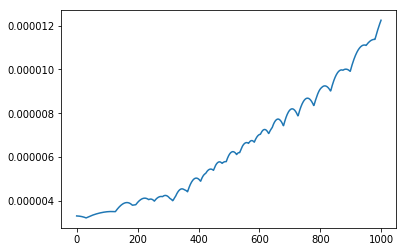

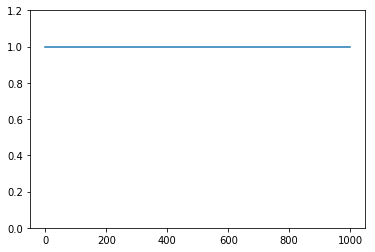

In [47]:
magJ =[]
enstrophy = []
for i in range(M):
    magJ.append(np.amax(gradJ[i]))
    enstrophy.append(vt.h1norm(u[i]))
    
plt.plot(magJ)
plt.show()
plt.plot(enstrophy)
plt.ylim([0,1.2])
plt.show()

In [60]:
import os    
plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=12)
output_path='output/'
os.system('mkdir ' + output_path)
os.system('rm ' + output_path + 'images/*')
os.system('mkdir ' + output_path + 'images/')
    
N_grid = 512
st_grid = tools.ScalarTool(N_grid,L)
th_git = np.zeros((M,N,N))
th_git[0]=th0
u_git = copy.copy(u)
count = 0
for i in range(M-1):
    th_git[i+1] = th_git[i] + dt * f(th_git[i],u_git[i])
#     if np.mod(i,1)==0:
#         fig = plt.figure()
#         st_grid.plot(increase_res(th_git[i],N_grid),high_quality=True)
#         #st.plot(th[i])
#         plt.title('Time = %.3f' % time_array[i])
#         plt.savefig(output_path + 'images/' + "image%.4d.png" %
#                     count, format='png',dpi=300)
#         plt.show()
        
#         vt.plot(u_git[i])
#         plt.show()
#         count += 1
        
# os.system("ffmpeg -y -framerate 20 -i " + output_path + 'images/'
#           "image%04d.png -c:v libx264 -pix_fmt yuv420p " + output_path + "movie.mp4")

In [62]:
hm1norm_hist_git = np.zeros(M)
l2norm_hist_git = np.zeros(M)
u_h1norm_hist_git = np.zeros(M)

for i in range(M):
    hm1norm_hist_git[i] = st.hm1norm(th_git[i])
    l2norm_hist_git[i]= st.l2norm(th_git[i])
    u_h1norm_hist_git[i] = st.l2norm(vt.curl(u_git[i]))

In [64]:
N_grid = 512
st_grid = tools.ScalarTool(N_grid,L)

sol_lit = lit.sim(N=N,M=M-1,Pe = np.inf,plot=False,T=T,save_th_every=1,save_u_every=1)
u_lit = np.array(sol_lit.hist_u)
time_array = np.array(sol_lit.hist_u_time)
th_lit = np.array(sol_lit.hist_th)

for i in range(M-1):
    th_lit[i+1] = th_lit[i] + dt * f(th_lit[i],u_lit[i])
#     if np.mod(i,10)==0:
#         st_grid.plot(increase_res(th_lit[i],N_grid))
# #         plt.savefig(output_path + 'images/' + "image%.4d.png" %
# #             i, format='png')
#         #st.plot(th[i])
#         plt.show()
#         vt.plot(u_lit[i])
#         #plt.title('time = ' , time_array[i])
#         plt.show()
        

dt =  0.003003003003003003


In [66]:
hm1norm_hist_lit = np.zeros(M)
l2norm_hist_lit = np.zeros(M)
u_h1norm_hist_lit = np.zeros(M)

for i in range(M):
    hm1norm_hist_lit[i] = st.hm1norm(th_lit[i])
    l2norm_hist_lit[i]= st.l2norm(th_lit[i])
    u_h1norm_hist_lit[i] = st.l2norm(vt.curl(u_lit[i]))

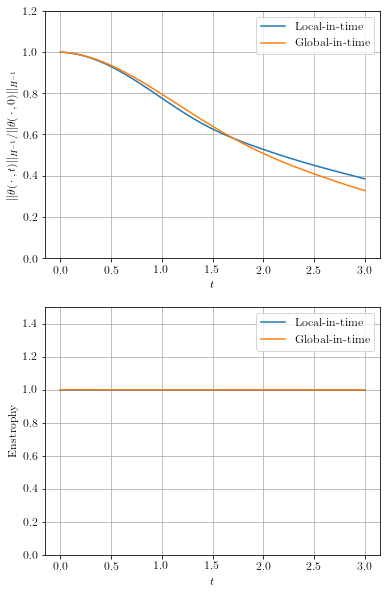

In [91]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=12)
#matplotlib.rc('xtick', labelsize=20) 
#matplotlib.rc('ytick', labelsize=20) 

plt.figure(figsize = (6,10))
plt.subplot(211)
plt.plot(time_array,hm1norm_hist_lit/hm1norm_hist_lit[0],label='Local-in-time')
plt.plot(time_array,hm1norm_hist_git/hm1norm_hist_git[0],label='Global-in-time')
plt.legend()
plt.ylabel('$\| \\theta(\,\cdot\,,t)\|_{H^{-1}} / \| \\theta(\,\cdot\,,0)\|_{H^{-1}}$')
plt.xlabel('$t$')
plt.grid('on')
plt.ylim([0,1.2])


# plt.figure()
# plt.plot(time_array,l2norm_hist_lit,label = 'LIT')
# plt.plot(time_array,l2norm_hist_git,label = 'GIT')
# plt.ylim([0,1.5*max(l2norm_hist_lit)])
# plt.legend()

plt.subplot(212)
plt.plot(time_array,u_h1norm_hist_lit**2.,label = 'Local-in-time')
plt.plot(time_array,u_h1norm_hist_git**2.,label = 'Global-in-time')
plt.ylim([0,1.5*max(u_h1norm_hist_lit)])
plt.legend()
plt.xlabel('$t$')
plt.ylabel('Enstrophy')
plt.grid('on')
plt.savefig('lit_vs_git_N64_T3p0_kappa0_L1_gamma1p0.eps',format='eps',dpi=300)
plt.show()

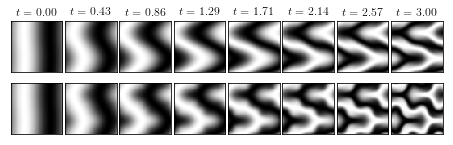

In [96]:
cmap = plt.cm.gray

pe_ind = 4
#final_time = (time_inf[ind_inf])
final_time = T
num_frames = 8

times2plot = np.linspace(time_array[0],final_time,num_frames)
indicies2plot_u= [ np.abs(time_array - times2plot[i]).argmin() for i in range(len(times2plot))] 
indicies2plot_l= [ np.abs(time_array - times2plot[i]).argmin() for i in range(len(times2plot))] 
#ind = np.abs(l2 - 10.0**(-12)).argmin()
#(tsteps,N,_) = np.shape(th_hist)
#st= ScalarTool(N,L)

plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=10)

fig_width = 6
fig_height = 2.1*fig_width/num_frames

f, (axes_u,axes_l) = plt.subplots(2,len(indicies2plot_l),sharey = True,figsize=(fig_width,fig_height))

end_ind_u=indicies2plot_u[-1]
    
for i,index in enumerate(indicies2plot_u):
    if index <= end_ind_u:
        im = axes_u[i].imshow(np.transpose(th_lit[index]),
                        cmap=cmap,
                        extent=(0, L, 0, L),
                        origin="lower",
                             vmin = -1.0,
                             vmax = 1.0)
    else:
        axes_u[i].get_xaxis().set_visible(False)
        axes_u[i].get_yaxis().set_visible(False)
        axes_u[i].axis('off')
        
    axes_u[i].set_xticks([])
    axes_u[i].set_yticks([])
    
    

    
    
for i,index in enumerate(indicies2plot_l):
    im = axes_l[i].imshow(np.transpose(th_git[index]),
                    cmap=cmap,
                    extent=(0, L, 0, L),
                    origin="lower")
    axes_l[i].set_xticks([])
    axes_l[i].set_yticks([])
    #axes_l[i].set_title('$t = %.2f $' % time[index])
    axes_u[i].set_title('$t = %.2f $' % time_array[index])

f.subplots_adjust(wspace = 0.05, bottom=0.0, left=0.0, top = 1.0, right=1.0)
plt.savefig('film.eps',dpi = 300, format = 'eps',bbox_inches='tight')
